# Laboratorio di simulazione numerica

In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['text.usetex'] = True
import numpy as np
import math
import string
import os

#### Exercise 08.1

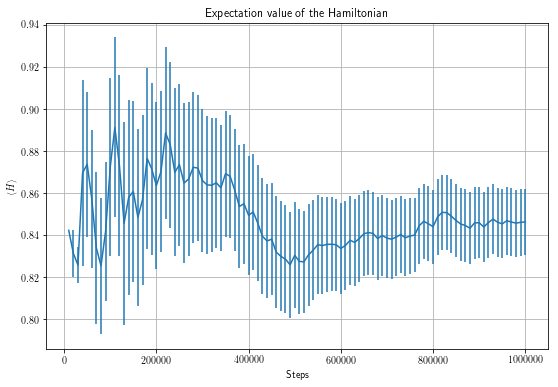

In [2]:
steps, avg, err = np.loadtxt("exercise08-1/energy.dat", unpack = True)

plt.figure(1, figsize = (9,6))
plt.errorbar(steps, avg, yerr = err)
plt.title("Expectation value of the Hamiltonian")
plt.ylabel(r"$\langle H\rangle$")
plt.xlabel("Steps")
plt.grid(True)
plt.show()

#### Exercise 08.2

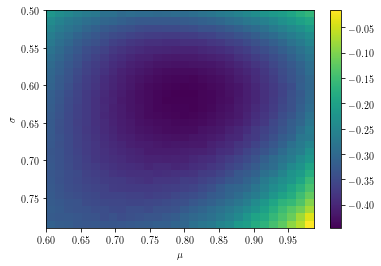

In [16]:
prefix = "exercise08-2/"
mu, sigma, energy_avg, energy_err = np.loadtxt(prefix + "grid.dat", unpack = True)

N = int(np.sqrt(len(mu)))
grid = energy_avg.reshape((N, N)).T

# In order to see the minimum more easily, and knowing it
# is negative, I will clip the values in 'grid', keeping
# only the negative ones.
grid = grid.clip(None, 0)

fig, axes = plt.subplots()
im = plt.imshow(grid, extent = (mu.min(), mu.max(), sigma.max(), sigma.min()),
           interpolation = "nearest")

axes.set_xlabel(r"$\mu$")
axes.set_ylabel(r"$\sigma$")
axes.set_aspect("auto")
fig.colorbar(im)
plt.show()

Jugdging by the plot above, the minimum seems to lie close to $\mu=0.82$ and $\sigma=0.62$. These are the values I choose to compare the trial wavefunction with the numerical, exact, one, in the following plots.

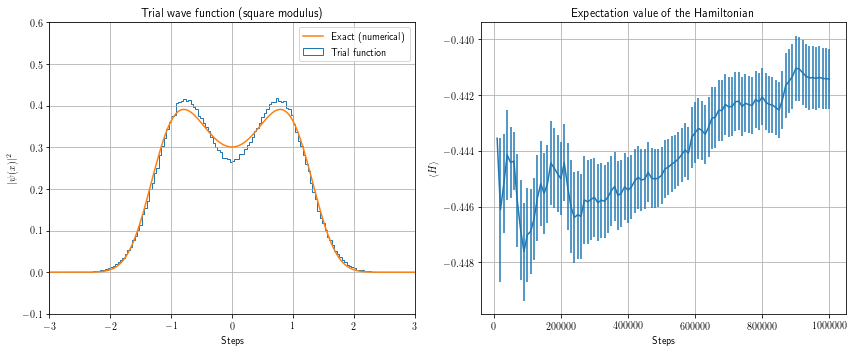

In [24]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
axes = axes.flatten()

# Re-run the simulation with the optimal parameters found before.
best_mu, best_sigma = 0.82, 0.62
os.chdir("/home/studenti/davide.ferracin/lab-simulazione-numerica/exercise08/exercise08-2/")
os.system("./exercise08-2 %.3f" % (best_mu) + " " + "%.3f" % (best_sigma))

# Gather the data.
drawn_points = np.loadtxt("drawn_points.dat", unpack = True)
steps, avg, err = np.loadtxt("energy.dat", unpack = True)

# Histogram of the square modulus of the wave function.
axes[0].hist(
    drawn_points,
    bins = 200,
    range = (-4, 4),
    density = True,
    histtype = "step",
    label = "Trial function"
)
axes[0].set_title("Trial wave function (square modulus)")
axes[0].set_ylabel(r"$|\psi(x)|^2$")
axes[0].set_xlabel("Steps")
axes[0].grid(True)

# Expectation value of the Hamiltonian.
axes[1].errorbar(steps, avg, yerr = err)
axes[1].set_title("Expectation value of the Hamiltonian")
axes[1].set_ylabel(r"$\langle H\rangle$")
axes[1].set_xlabel("Steps")
axes[1].grid(True)

# Numerical approximation of the exact probability density.
n_points = 1000 # Number of iterations
x = np.linspace(-4, 4, n_points)
dx = x[1] - x[0] # Step size

# Discrete "second derivative matrix operator": multiply a
# vector by this matrix and divide by the step size to
# obtain its discrete second derivative, calculated using
# the central differences method
# f'' = (f_1 - 2 f_0 + f_-1) / dx^2.
laplacian = np.diag(np.ones(n_points - 1), -1) - 2 * np.diag(np.ones(n_points), 0) + np.diag(np.ones(n_points - 1), 1)

# Potential energy
V = [(p**2 - 2.5) * p**2 for p in x]
# Hamiltonian matrix
H = -laplacian / (2 * dx**2) + np.diag(V)

# Compute the eigenvectors and their eigenvalues.
E, psi = np.linalg.eigh(H)

# Take the transpose, then normalize.
psi = np.transpose(psi)
psi = psi / np.sqrt(dx)

axes[0].plot(x, (psi[0])**2, label = "Exact (numerical)")
axes[0].set_xlim((-3, 3))
axes[0].set_ylim((-0.1, 0.6))
axes[0].legend()

fig.tight_layout()
plt.show()

#### Exercise 08.3
The folllowing plots show the results of the *path-integral ground-state* Monte Carlo algorithm: on the left, the ground state probability density; on the right, the expectation value of the Hamiltonian as the number of blocks increases.

##### Flat trial wave function
These plots refer to the simulation using $\psi(x)=1$ as a trial wave function.

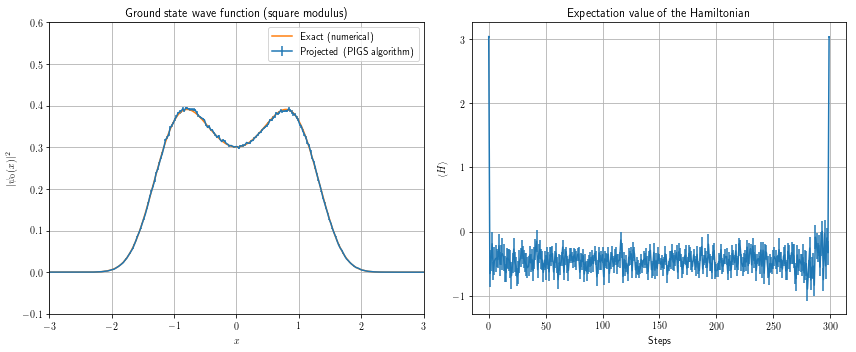

In [28]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
axes = axes.flatten()
prefix = "/home/studenti/davide.ferracin/lab-simulazione-numerica/exercise08/exercise08-3/"

# Histogram of the square modulus of the wave function.
x_bins, h_avg, h_err = np.loadtxt(prefix + "probability.dat", unpack = True)

axes[0].errorbar(x_bins, h_avg, yerr = h_err, label = "Projected (PIGS algorithm)")
axes[0].set_title("Ground state wave function (square modulus)")
axes[0].set_ylabel(r"$|\psi_0(x)|^2$")
axes[0].set_xlabel(r"$x$")
axes[0].plot(x, (psi[0])**2, label = "Exact (numerical)")
axes[0].set_xlim((-3, 3))
axes[0].set_ylim((-0.1, 0.6))
axes[0].legend()
axes[0].grid(True)

steps, p_avg, p_err = np.loadtxt(prefix + "potential.dat", unpack = True)
steps, k_avg, k_err = np.loadtxt(prefix + "kinetic.dat", unpack = True)
# Since the total energy is expressed only in terms of the potential and
# kinetic ones, I'll propagate p_err and k_err to e_err.
e_avg = p_avg + k_avg
e_err = np.sqrt(p_err**2 + k_err**2)

axes[1].errorbar(steps, e_avg, yerr = e_err)
axes[1].set_title("Expectation value of the Hamiltonian")
axes[1].set_ylabel(r"$\langle H\rangle$")
axes[1].set_xlabel("Steps")
axes[1].grid(True)

fig.tight_layout()
plt.show()

##### Double-gaussian wave function
These plots refer to the simulation using $\psi(x)=\exp\bigl(-\frac12(\frac{x-\mu}{\sigma})^2\bigr)+\exp\bigl(-\frac12(\frac{x+\mu}{\sigma})^2\bigr)$ as a trial wave function.

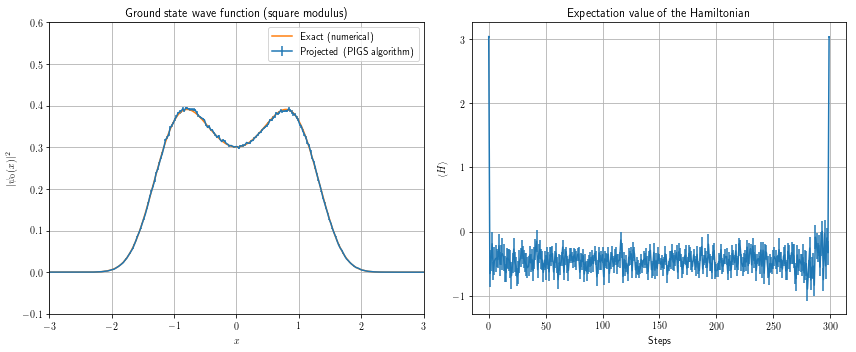

In [26]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
axes = axes.flatten()

# Histogram of the square modulus of the wave function.
x_bins, h_avg, h_err = np.loadtxt(prefix + "probability.dat", unpack = True)

axes[0].errorbar(x_bins, h_avg, yerr = h_err, label = "Projected (PIGS algorithm)")
axes[0].set_title("Ground state wave function (square modulus)")
axes[0].set_ylabel(r"$|\psi_0(x)|^2$")
axes[0].set_xlabel(r"$x$")
axes[0].grid(True)
axes[0].plot(x, (psi[0])**2, label = "Exact (numerical)")
axes[0].set_xlim((-3, 3))
axes[0].set_ylim((-0.1, 0.6))
axes[0].legend()
axes[0].grid(True)

steps, p_avg, p_err = np.loadtxt(prefix + "potential.dat", unpack = True)
steps, k_avg, k_err = np.loadtxt(prefix + "kinetic.dat", unpack = True)
# Since the total energy is expressed only in terms of the potential and
# kinetic ones, I'll propagate p_err and k_err to e_err.
e_avg = p_avg + k_avg
e_err = np.sqrt(p_err**2 + k_err**2)

axes[1].errorbar(steps, e_avg, yerr = e_err)
axes[1].set_title("Expectation value of the Hamiltonian")
axes[1].set_ylabel(r"$\langle H\rangle$")
axes[1].set_xlabel("Steps")
axes[1].grid(True)

fig.tight_layout()
plt.show()

##### Simulation at a positive temperature
The following shows the results of the *path-integral* Monte Carlo algorithm, simulating a system at a positive temperature. The plot shows the wave function of the system at the temperature increases.

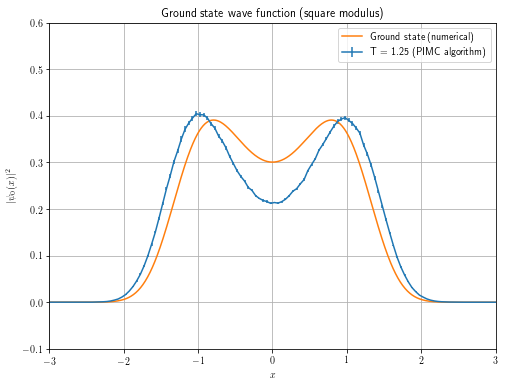

In [31]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 6))

# Histogram of the square modulus of the wave function.
x_bins, h_avg, h_err = np.loadtxt(prefix + "probability.dat", unpack = True)

axes.errorbar(x_bins, h_avg, yerr = h_err, label = "T = 1.25 (PIMC algorithm)")
axes.set_title("Ground state wave function (square modulus)")
axes.set_ylabel(r"$|\psi_0(x)|^2$")
axes.set_xlabel(r"$x$")
axes.grid(True)
axes.plot(x, (psi[0])**2, label = "Ground state (numerical)")
axes.set_xlim((-3, 3))
axes.set_ylim((-0.1, 0.6))
axes.legend()
axes.grid(True)

plt.show()